<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

Автор материала: Data Science интерн Ciklum, студент магистерской программы CSDS UCU Виталий Радченко, программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №5
## <center> Случайный лес и логистическая регрессия в задачах кредитного скоринга и классификации отзывов к фильмам

#### Нашей главной задачей будет построение и настройка моделей для задач кредитного скоринга и анализа отзывов к фильмам. Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/7nbdvV).

Но для разминки решите первое задание.

**<font color='red'>Задание 1.</font>** В зале суда есть 7 присяжных, каждый из них по отдельности с вероятностью 80% может правильно определить, виновен подсудимый или нет. С какой вероятностью присяжные все вместе вынесут правильный вердикт, если решение принимается большинством голосов?

**<font color='red'>Варианты ответа:</font>**
- 20.97%
### - 80.00%
- 83.70%
- 96.66%

Теперь перейдем непосредственно к машинному обучению.

#### Данные по кредитному скорингу представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	– Человек имел долгие просрочки выплат платежей за 2 года; бинарный признак

##### Независимые признаки
* age	                         – Возраст заёмщика кредитных средств (число полных лет); тип – integer
* NumberOfTime30-59DaysPastDueNotWorse	– Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней (но не больше) в течение последних двух лет; тип -	integer
* DebtRatio –	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип – float
* MonthlyIncome	– Месячный доход в долларах; тип –	float
* NumberOfTimes90DaysLate – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип –	integer
* NumberOfTime60-89DaysPastDueNotWorse –	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней (но не больше) в течение последних двух лет; тип – integer
* NumberOfDependents – Число человек в семье кредитозаёмщика; тип –	integer

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Напишем функцию, которая будет заменять значения NaN на медиану в каждом столбце таблицы. 

In [16]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

Считываем данные

In [17]:
data = pd.read_csv('../../data/credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Рассмотрим типы считанных данных

In [18]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Посмотрим на распределение классов в зависимой переменной

Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

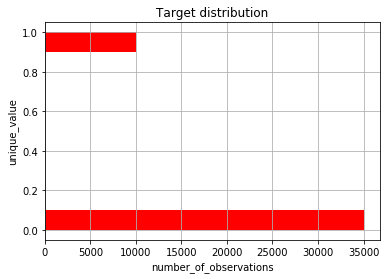

In [19]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts() / data.shape[0]

Выберем названия всех признаков, кроме прогнозируемого

In [20]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Применяем функцию, заменяющую все значения NaN на медианное значение соответствующего столбца.

In [21]:
table = impute_nan_with_median(data)

Разделяем целевой признак и все остальные – получаем обучающую выборку. 

In [22]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

Выведем версии основных библиотек – результат `GridSearchCV`, например, может отличаться в разных версиях `sklearn` даже при фиксированном `random_state`.

In [23]:
#!pip install watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [24]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g

CPython 3.5.2
IPython 6.1.0

numpy 1.13.0
scipy 0.19.0
pandas 0.20.2
matplotlib 2.0.2
sklearn 0.18.2

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.9.49-moby
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   : 9d0ee4f87fbbefa167645020c9ed5fb6a8f4e13d


In [12]:
!pip install -U scikit-learn

    100% |################################| 12.3MB 103kB/s ta 0:00:01    89% |############################    | 10.9MB 221kB/s eta 0:00:07    99% |############################### | 12.3MB 308kB/s eta 0:00:01
  Found existing installation: scikit-learn 0.18.2
    Uninstalling scikit-learn-0.18.2:
      Successfully uninstalled scikit-learn-0.18.2


# Бутстрэп

**<font color='red'>Задание 2.</font>** Сделайте интервальную оценку (на основе бутстрэпа) среднего дохода (MonthlyIncome) клиентов, просрочивших выплату кредита, и отдельно – для вовремя заплативших. Стройте 90% доверительный интервал. Найдите разницу между нижней границей полученного интервала для не просрочивших кредит и верхней границей – для просрочивших. 
То есть вас просят построить 90%-ые интервалы для дохода "хороших" клиентов $[good\_income\_lower, good\_income\_upper]$ и для "плохих" – $[bad\_income\_lower, bad\_income\_upper]$ и найти разницу $good\_income\_lower - bad\_income\_upper$.

Используйте пример из [статьи](https://habrahabr.ru/company/ods/blog/324402/). Поставьте `np.random.seed(17)`. Округлите ответ до целых.

**<font color='red'>Варианты ответа:</font>**
- 345
- 425
- 585
- 655

In [2]:
import numpy as np
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам

loyal_calls = table[table['SeriousDlqin2yrs']==0]['MonthlyIncome'].values 
churn_calls= table[table['SeriousDlqin2yrs']==1]['MonthlyIncome'].values
#loyal_calls = telecom_data[telecom_data['Churn'] == False]['Customer service calls'].values
#churn_calls= telecom_data[telecom_data['Churn'] == True]['Customer service calls'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
loyal_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(loyal_calls, 1000)]
churn_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(churn_calls, 1000)]

#  выводим интервальную оценку среднего
print("Service calls from loyal:  mean interval",  stat_intervals(loyal_mean_scores, 0.1))
print("Service calls from churn:  mean interval",  stat_intervals(churn_mean_scores, 0.1))

NameError: name 'table' is not defined

In [26]:
6296.61279076 - 5647.10314682

649.5096439400004

In [33]:
loyal_calls.shape[0], churn_calls.shape[0]

(35037, 10026)

------------------------------------------------

In [27]:
# Ваш код здесь
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [28]:
alpha = 0.1

In [29]:
p = [100 * alpha / 2., 100 * (1 - alpha / 2.)]
p

[5.0, 95.0]

In [30]:
np.random.seed(17)

In [31]:
bad_income =  stat_intervals(table[table['SeriousDlqin2yrs']==1]['MonthlyIncome'], 0.1)

In [32]:
bad_income

array([  1487.75,  12000.  ])

In [33]:
good_income =  stat_intervals(table[table['SeriousDlqin2yrs']==0]['MonthlyIncome'], 0.1)

In [34]:
good_income

array([  1500.,  13630.])

In [30]:
np.percentile([table[table['SeriousDlqin2yrs']==1]['MonthlyIncome']], [10.0, 90.0])

array([ 2000. ,  9382.5])

In [31]:
np.percentile(table[table['SeriousDlqin2yrs']==0]['MonthlyIncome'], [10.0, 90.0])

array([  2339.,  10833.])

In [21]:
np.percentile( table[~(table['NumberOfTime30-59DaysPastDueNotWorse']>0) 
      | (table['NumberOfTime60-89DaysPastDueNotWorse']>0) 
      | (table['NumberOfTimes90DaysLate']) 
     ]['MonthlyIncome'].values, [10.0, 90.0])

array([  2248.5,  10500. ])

In [22]:
np.percentile( table[(table['NumberOfTime30-59DaysPastDueNotWorse']>0) 
      | (table['NumberOfTime60-89DaysPastDueNotWorse']>0) 
      | (table['NumberOfTimes90DaysLate']) 
     ]['MonthlyIncome'].values, [10.0, 90.0])

array([  2178.,  10000.])

In [25]:
table[~(table['NumberOfTime30-59DaysPastDueNotWorse']>0) 
      | (table['NumberOfTime60-89DaysPastDueNotWorse']>0) 
      | (table['NumberOfTimes90DaysLate']) 
     ]['MonthlyIncome'].mean()

6155.284195226438

# Дерево решений, подбор гиперпараметров

Одной из основных метрик качества модели является площадь под ROC-кривой. Значения ROC-AUC лежат от 0 до 1. Чем ближе значение ROC-AUC к 1, тем качественнее происходит классификация моделью.

Найдите с помощью `GridSearchCV` гиперпараметры `DecisionTreeClassifier`, максимизирующие площадь под ROC-кривой. 

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Используем модуль `DecisionTreeClassifier` для построения дерева решений. Из-за несбалансированности классов  в целевом признаке добавляем параметр балансировки. Используем также параметр `random_state=17` для воспроизводимости результатов.

In [38]:
dt = DecisionTreeClassifier(random_state=17, class_weight='balanced')

Перебирать будем вот такие значения гиперпараметров:

In [39]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

Зафиксируем кросс-валидацию: стратифицированная, 5 разбиений с перемешиванием, не забываем про `random_state`.

In [22]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [43]:
gs = GridSearchCV?

In [ ]:
gs = GridSearchCV

In [ ]:
gs = GridSearchCV

In [44]:
clf = GridSearchCV(dt, tree_params, cv=skf, scoring='roc_auc')

In [45]:
clf.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [4, 5, 6, 7], 'max_depth': [5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [46]:
clf.best_score_

0.82030234762096355

In [15]:
from sklearn.model_selection import cross_val_score

In [50]:
cr_val = cross_val_score(dt, X, y, cv=skf)

In [55]:
cr_val

array([ 0.76658531,  0.76223233,  0.75621394,  0.75588105,  0.76287173])

In [16]:
from statistics import variance

In [54]:
variance(cr_val)*100

0.0021258055618537668

**<font color='red'>Задание 3.</font>**
Сделайте GridSearch с метрикой ROC AUC по гиперпараметрам из словаря `tree_params`. Какое максимальное значение ROC AUC получилось (округлите до 2 знаков после разделителя)? Назовем кросс-валидацию устойчивой, если стандартное отклонение метрики качества на кросс-валидации меньше 1%. Получилась ли кросс-валидация устойчивой при оптимальных сочетаниях гиперпараметров (т.е. обеспечивающих максимум среднего значения ROC AUC на кросс-валидации)?

**<font color='red'>Варианты ответа:</font>**
- 0.82, нет
- 0.84, нет
### - 0.82, да
- 0.84, да

In [14]:
# Ваш код здесь

# Простая реализация случайного леса

**<font color='red'>Задание 4.</font>**
Реализуйте свой собственный случайный лес с помощью `DecisionTreeClassifier` с лучшими параметрами из прошлого задания. В нашем лесу будет 10 деревьев, предсказанные вероятности которых вам нужно усреднить. 

Краткая спецификация: 
 - Используйте основу ниже
 - В методе `fit` в цикле (`i` от 0 до `n_estimators-1`) фиксируйте seed, равный (`random_state + i`). Почему именно так – неважно, главное чтоб на каждой итерации seed был новый, при этом все значения можно было бы воспроизвести
 - Зафиксировав seed, выберите **без замещения** `max_features` признаков, сохраните список выбранных id признаков в `self.feat_ids_by_tree`
 - Также сделайте bootstrap-выборку (т.е. **с замещением**) из множества id объектов 
 - Обучите дерево с теми же `max_depth`, `max_features` и `random_state`, что и у `RandomForestClassifierCustom` на выборке с нужным подмножеством объектов и признаков
 - Метод `fit` возвращает текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self`
 - В методе `predict_proba` опять нужен цикл по всем деревьям. У тестовой выборки нужно взять те признаки, на которых соответсвующее дерево обучалось, и сделать прогноз вероятностей (`predict_proba` уже для дерева). Метод должен вернуть усреднение прогнозов по всем деревьям.

Проведите кросс-валидацию. Какое получилось среднее значение ROC AUC на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
###  0.823 X3
- 0.833
- 0.843
- 0.853

In [10]:
from sklearn.model_selection import cross_val_score

from sklearn.base import BaseEstimator

class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=3, max_features=10, random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        # в данном списке будем хранить отдельные деревья
        self.trees = []
        # тут будем хранить списки индексов признаков, на которых обучалось каждое дерево 
        self.feat_ids_by_tree = []
        
    def fit(self, X, y):
        
        # Ваш код здесь
        pass
        
    
    def predict_proba(self, X):
        
        # Ваш код здесь
        pass

In [16]:
# Ваш код здесь

**<font color='red'>Задание 5.</font>**
Тут сравним нашу собственную реализацию случайного леса с `sklearn`-овской. Для этого воспользуйтесь `RandomForestClassifier(n_jobs=1, random_state=17)`, укажите все те же значения `max_depth` и `max_features`, что и раньше. Какое среднее значение ROC AUC на кросс-валидации мы в итоге получили? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
### - 0.823
- 0.833
- 0.843
- 0.853

In [11]:
from sklearn.ensemble import RandomForestClassifier
# Ваш код здесь

In [69]:
rfc = RandomForestClassifier(n_jobs=1, random_state=17, max_depth=3, max_features=7)

In [70]:
cr_val = cross_val_score(rfc, X, y, cv=skf, scoring='roc_auc')

In [71]:
cr_val

array([ 0.77556009,  0.77693562,  0.78185822,  0.77851379,  0.77830581])

In [72]:
cr_val.mean()

0.77823470609859169

# Случайный лес `sklearn`, подбор гиперпараметров

**<font color='red'>Задание 6.</font>** 
В 3 задании мы находили оптимальные гиперпараметры для одного дерева, но может быть, для ансамбля эти параметры дерева не будут оптимальными. Давайте проверим это с помощью `GridSearchCV` `(RandomForestClassifier(random_state=17)`).  Только теперь расширим перебираемые значения `max_depth` до 15 включительно, так как в лесу нужны деревья поглубже (а почему именно – вы поняли из [статьи](https://habrahabr.ru/company/ods/blog/324402/)). Какими теперь стали лучшие значения гиперпараметров?

**<font color='red'>Варианты ответа:</font>**
### - `max_depth=8, max_features=4`
- `max_depth=9, max_features=5`
- `max_depth=10, max_features=6`
- `max_depth=11, max_features=7`

In [75]:
max_depth_values = range(5, 16)
max_features_values = range(4, 8)
forest_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [76]:
rfc = RandomForestClassifier(n_jobs=1, random_state=17)

In [85]:
clf = GridSearchCV(rfc, forest_params, cv=skf, scoring='roc_auc')

In [86]:
clf.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': range(4, 8), 'max_depth': range(5, 16)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [87]:
clf.best_score_

0.83286806314143702

In [88]:
clf.best_params_

{'max_depth': 8, 'max_features': 4}

# Логистическая регрессия, подбор гиперпараметров

**<font color='red'>Задание 7.</font>**  Теперь сравним с логистической регрессией (укажем `class_weight='balanced'` и `random_state=17`). Сделайте полный перебор по параметру `C` из широкого диапазона значений `np.logspace(-8, 8, 17)`. 
Только сделаем это корректно и выстроим пайплайн – сначала масштабирование, затем обучение модели. 

Разберитесь с пайплайнами и проведите кросс-валидацию. Какое получилось лучшее значение средней ROC AUC? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.778
### - 0.788
- 0.798
- 0.808

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
logit = LogisticRegression(random_state=17, class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

In [90]:
# Ваш код здесь
clf = GridSearchCV(logit_pipe, logit_pipe_params, cv=skf, scoring='roc_auc')

In [91]:
clf.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logit__C': array([  1.00000e-08,   1.00000e-07,   1.00000e-06,   1.00000e-05,
         1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01,   1.00000e+02,   1.00000e+03,
         1.00000e+04,   1.00000e+05,   1.00000e+06,   1.00000e+07,
         1.00000e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [92]:
clf.best_score_

0.78786267573072055

In [93]:
clf.best_params_

{'logit__C': 100000.0}

# Логистическая регрессия и случайный лес на разреженных признаках

В случае небольшого числа признаков случайный лес показал себя лучше логистической регрессии. Однако один из главных недостатков деревьев проявляется при работе с разреженным данными, например с текстами. Давайте сравним логистическую регрессию и случайный лес в новой задаче.
Скачайте данные с отзывами к фильмам [отсюда](https://yadi.sk/d/pHZlDkg-3NSUQW).

In [20]:
# Загрузим данные
df = pd.read_csv("../../data/movie_reviews_train.csv", nrows=50000)

# Разделим данные на текст и целевой признак
X_text = df["text"]
y_text = df["label"]

# Соотношения классов
df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# будем разбивать на 3 фолда
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# в Pipeline будем сразу преобразовать наш текст и обучать логистическую регрессию
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features = 100000, ngram_range = (1, 3))),
    ('clf', LogisticRegression(random_state=17))])

NameError: name 'StratifiedKFold' is not defined

**<font color='red'>Задание 8.</font>** Сделайте полный перебор по параметру `C` из выборки [0.1, 1, 10, 100]. Какое лучшее значение ROC AUC получилось на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- 0.75
- 0.84
### - 0.85

In [110]:
# Ваш код здесь
#classifier_param = {'C': [0.1, 1, 10, 100]}
logit_pipe_params = {'clf__C': [0.1, 1, 10, 100]}

In [111]:
# Ваш код здесь
clf = GridSearchCV(classifier, logit_pipe_params, cv=skf, scoring='roc_auc')

In [112]:
clf.fit(X_text,y_text)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...alty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': [0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

In [113]:
clf.best_score_

0.85869298711881148

In [114]:
clf.best_params_

{'clf__C': 1}

**<font color='red'>Задание 9.</font>** Теперь попробуем сравнить со случайным лесом. Аналогично делаем перебор и получаем максимальное ROC AUC. Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- 0.75
- 0.84
- 0.85

In [18]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features = 100000, ngram_range = (1, 3))),
    ('clf', RandomForestClassifier(random_state=17, n_jobs=-1))])

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

In [19]:
# Ваш код здесь
rf_pipe_params = {'clf__min_samples_leaf': [1, 2, 3], 'clf__max_features':[0.3, 0.5, 0.7], 'clf__max_depth':[None]}

In [23]:
clf = GridSearchCV(classifier, rf_pipe_params, cv=skf, scoring='roc_auc')

In [24]:
%%time
clf.fit(X_text,y_text)

CPU times: user 2h 59min 10s, sys: 34 s, total: 2h 59min 43s
Wall time: 1h 35min 14s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...timators=10, n_jobs=-1, oob_score=False, random_state=17,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'clf__max_depth': [None], 'clf__max_features': [0.3, 0.5, 0.7], 'clf__min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [25]:
clf.best_score_

0.75571322703493615

In [26]:
clf.best_params_

{'clf__max_depth': None, 'clf__max_features': 0.3, 'clf__min_samples_leaf': 2}